<IPython.core.display.Javascript object>


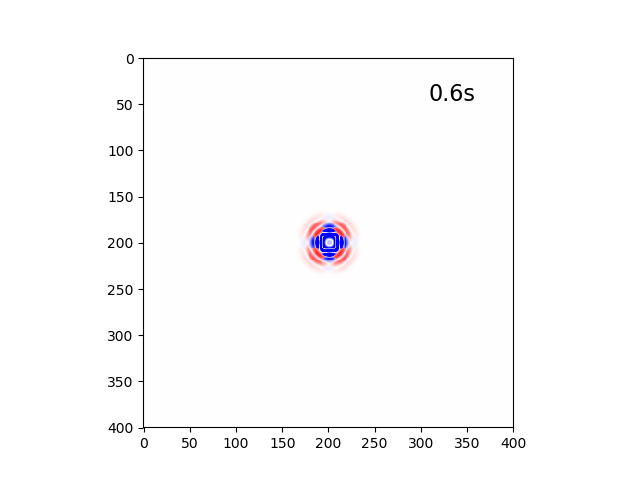

In [2]:
import numpy as np
import numba
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib nbagg

nx = nz = 400    # グリッド数
dx = dz = 75     # グリッド間隔（m）
dt = 5           # 時間間隔（ms）
nt = 1000        # 時間ステップ数（計算される時間は dt*nt となる
fc = 4.0         # 震源項の中心周波数（Hz）
vp = 6.0         # P波速度（km/s = m/ms）
vs = 3.464       # S波速度（km/s = m/ms）
ro = 2.6         # 密度（g/cm^3）
rig = ro*(vs**2) # 剛性率
lam = ro*(vp**2) - 2.0*ro*(vs**2) # ラメ定数ラムダ
ieqx = int(nx/2) # 震源のグリッド位置（x方向）
ieqz = int(nz/2) # 震源のグリッド位置（z方向）
plotstep=10 # スナップショットを出力する時間ステップ間隔

a1 = 1.0/24.0
a2 = 9.0/8.0

# 配列の定義
sxx = np.zeros((nx,nz))
szz = np.zeros((nx,nz))
sxz = np.zeros((nx,nz))
vx = np.zeros((nx,nz))
vz = np.zeros((nx,nz))
divrot = np.zeros((nx,nz))

# 震源項の設定(Ricker wavelet)
tt = (np.pi*fc*0.001*(np.arange(nt)*dt-1250.0/fc))**2
mxx = np.zeros(nt)
mzz = np.zeros(nt)
mxz = (1.0-2.0*tt)*np.exp(-tt)

# vx, vz を１タイムステップ進める
@numba.jit('(f8[:,:],f8[:,:],f8[:,:],f8[:,:],f8[:,:])')
def stepV(vx, vz, sxx, szz, sxz):
    for i in range(2,nx-2):
        for j in range(2,nz-2):
            vx[i,j] = vx[i,j] + dt*((sxx[i+1,j]-sxx[i,j])*a2/dx \
                -(sxx[i+2,j]-sxx[i-1,j])*a1/dx \
                +(sxz[i,j]-sxz[i,j-1])*a2/dz \
                -(sxz[i,j+1]-sxz[i,j-2])*a1/dz)/ro
            vz[i,j] = vz[i,j] + dt*((sxz[i,j]-sxz[i-1,j])*a2/dx \
                -(sxz[i+1,j]-sxz[i-2,j])*a1/dx \
                +(szz[i,j+1]-szz[i,j])*a2/dz \
                -(szz[i,j+2]-szz[i,j-1])*a1/dz)/ro

# sxx, szz, sxz を１タイムステップ進める
@numba.jit('(f8[:,:],f8[:,:],f8[:,:], f8[:,:], f8[:,:], f8[:], f8[:], f8[:], i8)')
def stepS(sxx, szz, sxz, vx, vz, mxx, mzz, mxz, it):
    for i in range(2,nx-2):
        for j in range(2,nz-2):
            dxvx = (vx[i,j]-vx[i-1,j])*a2/dx \
                - (vx[i+1,j]-vx[i-2,j])*a1/dx
            dzvz = (vz[i,j]-vz[i,j-1])*a2/dz \
                - (vz[i,j+1]-vz[i,j-2])*a1/dz
            sxx[i,j] = sxx[i,j] + (lam+2.0*rig)*dt*dxvx+lam*dt*dzvz
            szz[i,j] = szz[i,j] + (lam+2.0*rig)*dt*dzvz+lam*dt*dxvx
            sxz[i,j] = sxz[i,j] + rig*dt*((vz[i+1,j]-vz[i,j])*a2/dx \
                 -(vz[i+2,j]-vz[i-1,j])*a1/dx \
                 +(vx[i,j+1]-vx[i,j])*a2/dz \
                 -(vx[i,j+2]-vx[i,j-1])*a1/dz)
    sxx[ieqx,ieqz] = sxx[ieqx,ieqz] - mxx[it]
    szz[ieqx,ieqz] = szz[ieqx,ieqz] - mzz[it]
    sxz[ieqx,ieqz] = sxz[ieqx,ieqz] - mxz[it]

    # 応力降下（stress glut）
    sxx[ieqx,ieqz] = sxx[ieqx,ieqz] - mxx[it]
    szz[ieqx,ieqz] = szz[ieqx,ieqz] - mzz[it]
    sxz[ieqx,ieqz] = sxz[ieqx,ieqz] - mxz[it]
    
# 波動場のdivergenceとrotationを計算
@numba.jit('(f8[:,:],f8[:,:],f8[:,:])')
def calDivRot(vx, vz, divrot):
    for i in range(1,nx-1):
        for j in range(1,nz):
            div = 2*np.abs((vx[i,j]-vx[i-1,j])/dx+(vz[i,j]-vz[i,j-1])/dz)
            rot = np.abs((vx[i,j]-vx[i,j-1])/dz+(vz[i+1,j-1]-vz[i,j-1])/dx)
            divrot[i,j] = div if div >= rot else -rot

# プロットの準備
fig = plt.figure()
ax = plt.gca()
ims = []

# 0 ~ nt まで計算を進める
for it in range(nt):
    stepV(vx,vz, sxx, szz, sxz)  # vx, vzの計算
    stepS(sxx,szz,sxz, vx, vz, mxx, mzz, mxz, it)   # sxx, szz, sxzの計算

    # 波動場のスナップショットを描画する
    if (it % plotstep) == 0:
        calDivRot(vx, vz, divrot)
        im = plt.imshow(divrot, vmin=-0.0001, vmax=0.0001, cmap="bwr")
        label = plt.text(0.9, 0.9, f"{it*dt*0.001:.1f}s", fontsize=16, ha='right', va='center', transform=ax.transAxes)
        ims.append([im, label])

# 描画したスナップショットを元に動画を作成する．
ani = animation.ArtistAnimation(fig, ims, interval=1000/24)
# ani.save('seis.mp4', writer="ffmpeg") # ffmpegがあれば動画作成可能
plt.show() # スナップショットを表示する
